# Lectura 33: Lazy API - Plan y ejecución de una consulta

## Plan de consulta

Para cualquier consulta lazy, Polars tiene ambos:

- **Un plan no optimizado:** este contiene el conjunto de pasos en código qu ele proporcionamos.
- **Un plan optimizado:** que contiene cambios realizados por el optimizador de consultas

Consideremos la siguiente consulta:

In [1]:
import polars as pl
from polars import col

query = (
    pl.scan_parquet('./data/vuelos/vuelos.parquet')
    .with_columns(tiempo_aire_hrs=(col('AIR_TIME') / 60))
    .filter(col('MONTH') > 7)
)

Primero visualizaremos el plan no optimizado con la función `show_graph` estableciendo el parámetro `optimized=False`.

**Nota Importante:**

Para visualizar los gráficos será necesario instalar la librería `graphviz` la cual la podemos instalar ejecutando en una celda de código el comando `pip install graphviz`. Además, necesitará instalar el programa `graphviz` en su sistema operativo.

**Para errores y dudas pueden visitar el siguiente enlace:**

(Solución de errores graphviz)[https://stackoverflow.com/questions/35064304/runtimeerror-make-sure-the-graphviz-executables-are-on-your-systems-path-aft]

In [3]:
# Descomentar y ejecutar solo si no está instalada la librería graphviz
# !pip3 install graphviz

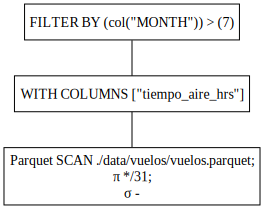

In [4]:
query.show_graph(optimized=False)

La visualización del plan de consulta debe leerse de abajo hacia arriba. Expliquemos como leer esta salida:

- Cada rectángulo corresponde a una etapa del plan de consulta
- El `sigma` significa SELECCIÓN e indica cualquier condición de filtro
- El `pi` significa PROYECCIÓN e indica la elección de un subconjunto de columnas

Ahora visualizaremos el pan de consulta optimizado.

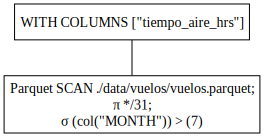

In [6]:
query.show_graph()

### Imprimir el plan de consulta

También podemos imprimir el plan no optimizado con `explain(optimized=False)`.

In [5]:
query.explain(optimized=False)

'FILTER [(col("MONTH")) > (7)] FROM\n WITH_COLUMNS:\n [[(col("AIR_TIME")) / (60)].alias("tiempo_aire_hrs")]\n\n    Parquet SCAN ./data/vuelos/vuelos.parquet\n    PROJECT */31 COLUMNS'

Imprimamos el plan de consulta optimizado.

In [7]:
query.explain()

' WITH_COLUMNS:\n [[(col("AIR_TIME")) / (60)].alias("tiempo_aire_hrs")]\n\n    Parquet SCAN ./data/vuelos/vuelos.parquet\n    PROJECT */31 COLUMNS\n    SELECTION: [(col("MONTH")) > (7)]'